In [1]:
import os
import numpy as np
import pandas as pd
import cv2
import tensorflow
from tensorflow import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pydicom as dcm
import math
%matplotlib inline

from tensorflow.keras.layers import Layer, Convolution2D, Flatten, Dense, LeakyReLU
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape, GlobalAveragePooling2D
from tensorflow.keras import losses, optimizers, regularizers
from tensorflow.keras.layers import Activation, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.metrics import r2_score
from keras.models import Sequential 
from keras.layers import Dense, Dropout
from keras.layers import Conv2D 
from keras.layers import MaxPooling2D 
from keras.layers import Flatten, GlobalAveragePooling2D,GlobalMaxPooling2D

import warnings
warnings.filterwarnings('ignore')

class_labels = pd.read_csv('C:/Users/Yogita/Downloads/stage_2_dataset/Copy of stage_2_detailed_class_info.csv')
labels = pd.read_csv('C:/Users/Yogita/Downloads/stage_2_dataset/Copy of stage_2_train_labels.csv')

C:\Users\Yogita\AppData\Local\Temp\ipykernel_25896\2341517503.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [6]:
class_labels.head()

patientId                         class
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6  No Lung Opacity / Not Normal
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd  No Lung Opacity / Not Normal
2  00322d4d-1c29-4943-afc9-b6754be640eb  No Lung Opacity / Not Normal
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5                        Normal
4  00436515-870c-4b36-a041-de91049b9ab4                  Lung Opacity

In [7]:
labels.head()

patientId      x      y  width  height  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1

In [8]:
labels.shape

(30227, 6)

In [9]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   x          9555 non-null   float64
 2   y          9555 non-null   float64
 3   width      9555 non-null   float64
 4   height     9555 non-null   float64
 5   Target     30227 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 1.4+ MB


In [10]:
# we can see that all the null column values are with Target 0 indicating that those patients do not have penumonia
labels[labels.isnull().any(axis=1)].Target.value_counts()

Target
0    20672
Name: count, dtype: int64

In [11]:
# we can see that all the non null column values are with Target 1 indicating that those patients have pneumonia
labels[~labels.isnull().any(axis=1)].Target.value_counts()

Target
1    9555
Name: count, dtype: int64

In [12]:
# Distubution of Targets , there are 20672 records with no pneumonia and 9555 with pneumonia
labels.Target.value_counts()

Target
0    20672
1     9555
Name: count, dtype: int64

In [2]:
training_data = pd.concat([labels, class_labels['class']], axis = 1)
training_data.head()

patientId      x      y  width  height  Target  \
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0   
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0   
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0   
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0   
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1   

                          class  
0  No Lung Opacity / Not Normal  
1  No Lung Opacity / Not Normal  
2  No Lung Opacity / Not Normal  
3                        Normal  
4                  Lung Opacity

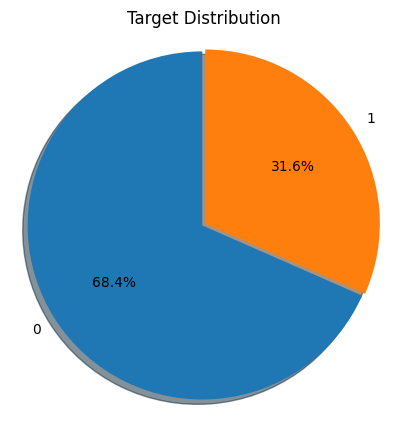

In [3]:
# Disturbution of Target, there are 31% of patients with pneumonia and the remaining are no pneumonia.

label_count=labels['Target'].value_counts()
explode = (0.01,0.01)  

fig1, ax1 = plt.subplots(figsize=(5,5))
ax1.pie(label_count.values, explode=explode, labels=label_count.index, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 
plt.title('Target Distribution')
plt.show()

In [4]:
print("Are there Unique Patients In Data Set ?? " ,labels['patientId'].is_unique)

Are there Unique Patients In Data Set ??  False


In [5]:
duplicateRowsDF = labels[labels.duplicated(['patientId'])]
duplicateRowsDF.shape

(3543, 6)

In [13]:
duplicateRowsDF.head(2)

patientId      x      y  width  height  Target
5  00436515-870c-4b36-a041-de91049b9ab4  562.0  152.0  256.0   453.0       1
9  00704310-78a8-4b38-8475-49f4573b2dbb  695.0  575.0  162.0   137.0       1

In [14]:
## Examining one of the patient id which is duplicate , we can see that the x,y, widht and height is not the same
## This indicates that the same patient has two bounding boxes in the same dicom image
labels[labels.patientId=='00436515-870c-4b36-a041-de91049b9ab4']

patientId      x      y  width  height  Target
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1
5  00436515-870c-4b36-a041-de91049b9ab4  562.0  152.0  256.0   453.0       1

In [15]:
class_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   patientId  30227 non-null  object
 1   class      30227 non-null  object
dtypes: object(2)
memory usage: 472.4+ KB


In [16]:
class_labels['class'].value_counts()

class
No Lung Opacity / Not Normal    11821
Lung Opacity                     9555
Normal                           8851
Name: count, dtype: int64

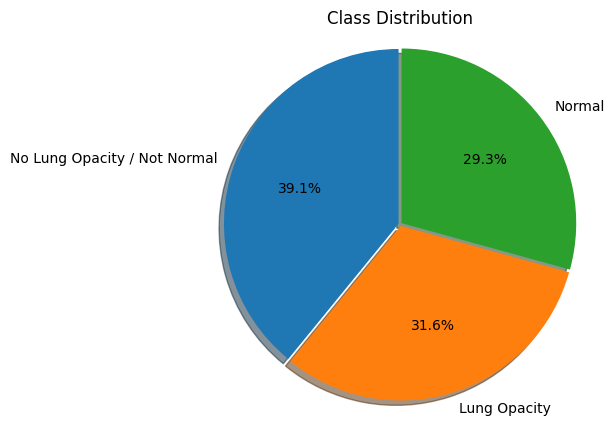

In [17]:
# Disturbution of Classes, there are 39% of patients with No Lung opacity , 29.3% Normal 
# and the remaining are with Lung Opacity
label_count=class_labels['class'].value_counts()
explode = (0.01,0.01,0.01)  

fig1, ax1 = plt.subplots(figsize=(5,5))
ax1.pie(label_count.values, explode=explode, labels=label_count.index, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 
plt.title('Class Distribution')
plt.show()

In [18]:
duplicateClassRowsDF = class_labels[class_labels.duplicated(['patientId'])]
duplicateClassRowsDF.shape

## There are 3543 duplicates similar to the labels dataset

(3543, 2)

In [19]:
# The same patient id has the same class even though they are duplicate
class_labels[class_labels.patientId=='00704310-78a8-4b38-8475-49f4573b2dbb']

patientId         class
8  00704310-78a8-4b38-8475-49f4573b2dbb  Lung Opacity
9  00704310-78a8-4b38-8475-49f4573b2dbb  Lung Opacity

Text(0.5, 1.0, 'Class and Target  Distrubution')

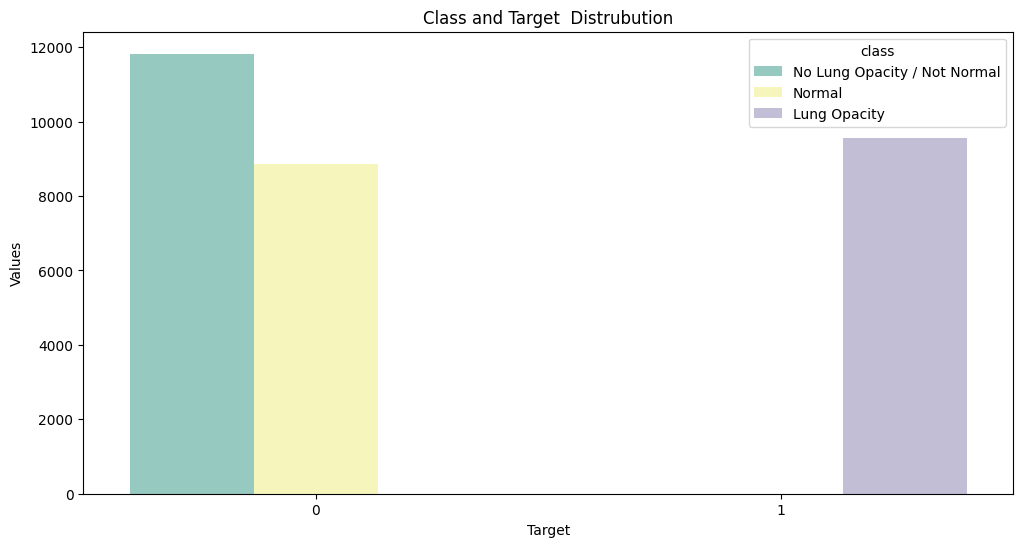

In [20]:
fig, ax = plt.subplots(nrows = 1, figsize = (12, 6))
temp = training_data.groupby('Target')['class'].value_counts()
data_target_class = pd.DataFrame(data = {'Values': temp.values}, index = temp.index).reset_index()
sns.barplot(ax = ax, x = 'Target', y = 'Values', hue = 'class', data = data_target_class, palette = 'Set3')
plt.title('Class and Target  Distrubution')

# it shows the class distrubution grouped by Target 
# Target 0 has only Normal or No Lung Opacity class
# Target 1 has only Lung Opacity class

In [23]:
import os
import pydicom as dcm
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import math

def inspectImages(data):
    img_data = list(data.T.to_dict().values())
    f, ax = plt.subplots(3,3, figsize=(16,18))
    for i, data_row in enumerate(img_data):
        patientImage = data_row['patientId']
        
        folder_name = 'stage_2_train_images'
        current_directory = os.getcwd()
        dcm_file = os.path.join('C:/Users/Yogita/Downloads/stage_2_train_images', '{}.dcm'.format(patientImage))  # Corrected folder name
        #dcm_file = "C:\Users\Ayush\Desktop\IIIT Delhi (Submissions)\stage_2_train_images\{}.dcm".format(patientImage)
        data_row_img_data = dcm.read_file(dcm_file)
        modality = data_row_img_data.Modality
        age = data_row_img_data.PatientAge
        sex = data_row_img_data.PatientSex
        data_row_img = dcm.dcmread(dcm_file)
        ax[i//3, i%3].imshow(data_row_img.pixel_array, cmap=plt.cm.bone) 
        ax[i//3, i%3].axis('off')
        ax[i//3, i%3].set_title('ID: {}\nModality: {} Age: {} Sex: {} Target: {}\nClass: {}\nBounds: {}:{}:{}:{}'.format(
                data_row['patientId'],
                modality, age, sex, data_row['Target'], data_row['class'], 
                data_row['x'],data_row['y'],data_row['width'],data_row['height']))
        label = data_row["class"]
        if not math.isnan(data_row['x']):
            x, y, width, height  =  data_row['x'],data_row['y'],data_row['width'],data_row['height']
            rect = patches.Rectangle((x, y),width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')

            # Draw the bounding box on top of the image
            ax[i//3, i%3].add_patch(rect)

    plt.show()


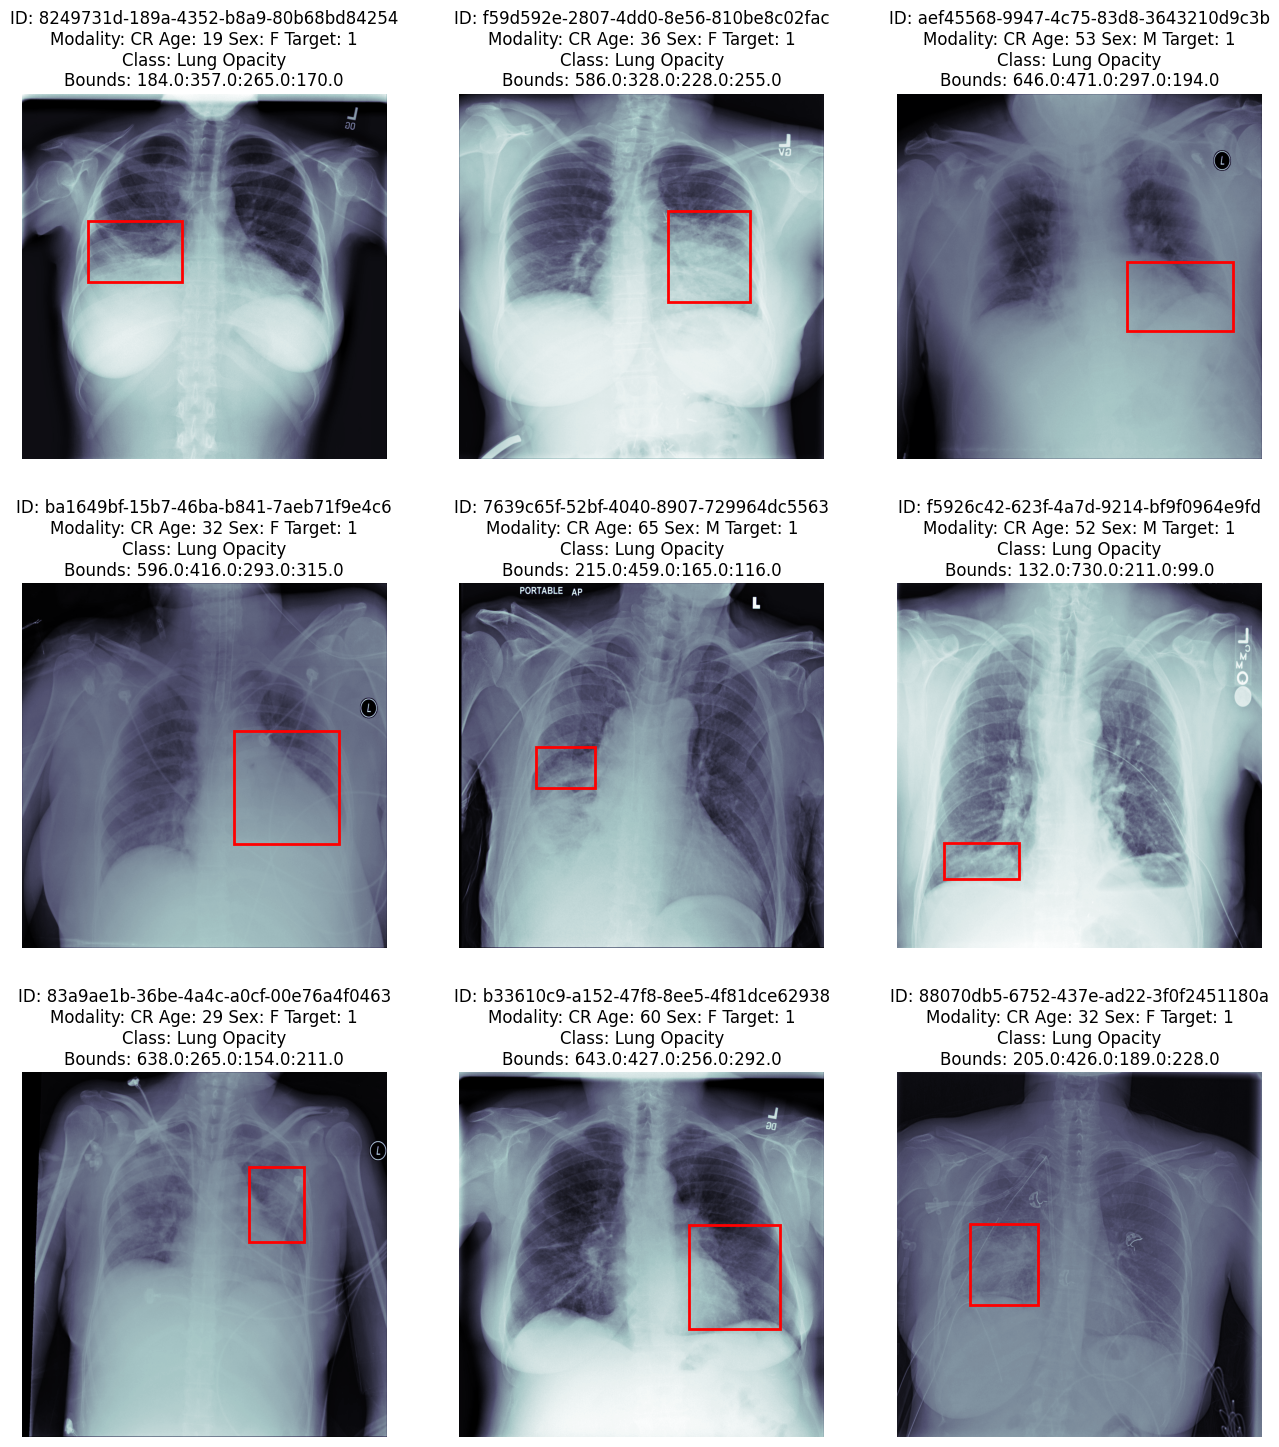

In [25]:
# checking few images which has pneuonia 
inspectImages(training_data[training_data['Target']==1].sample(9))

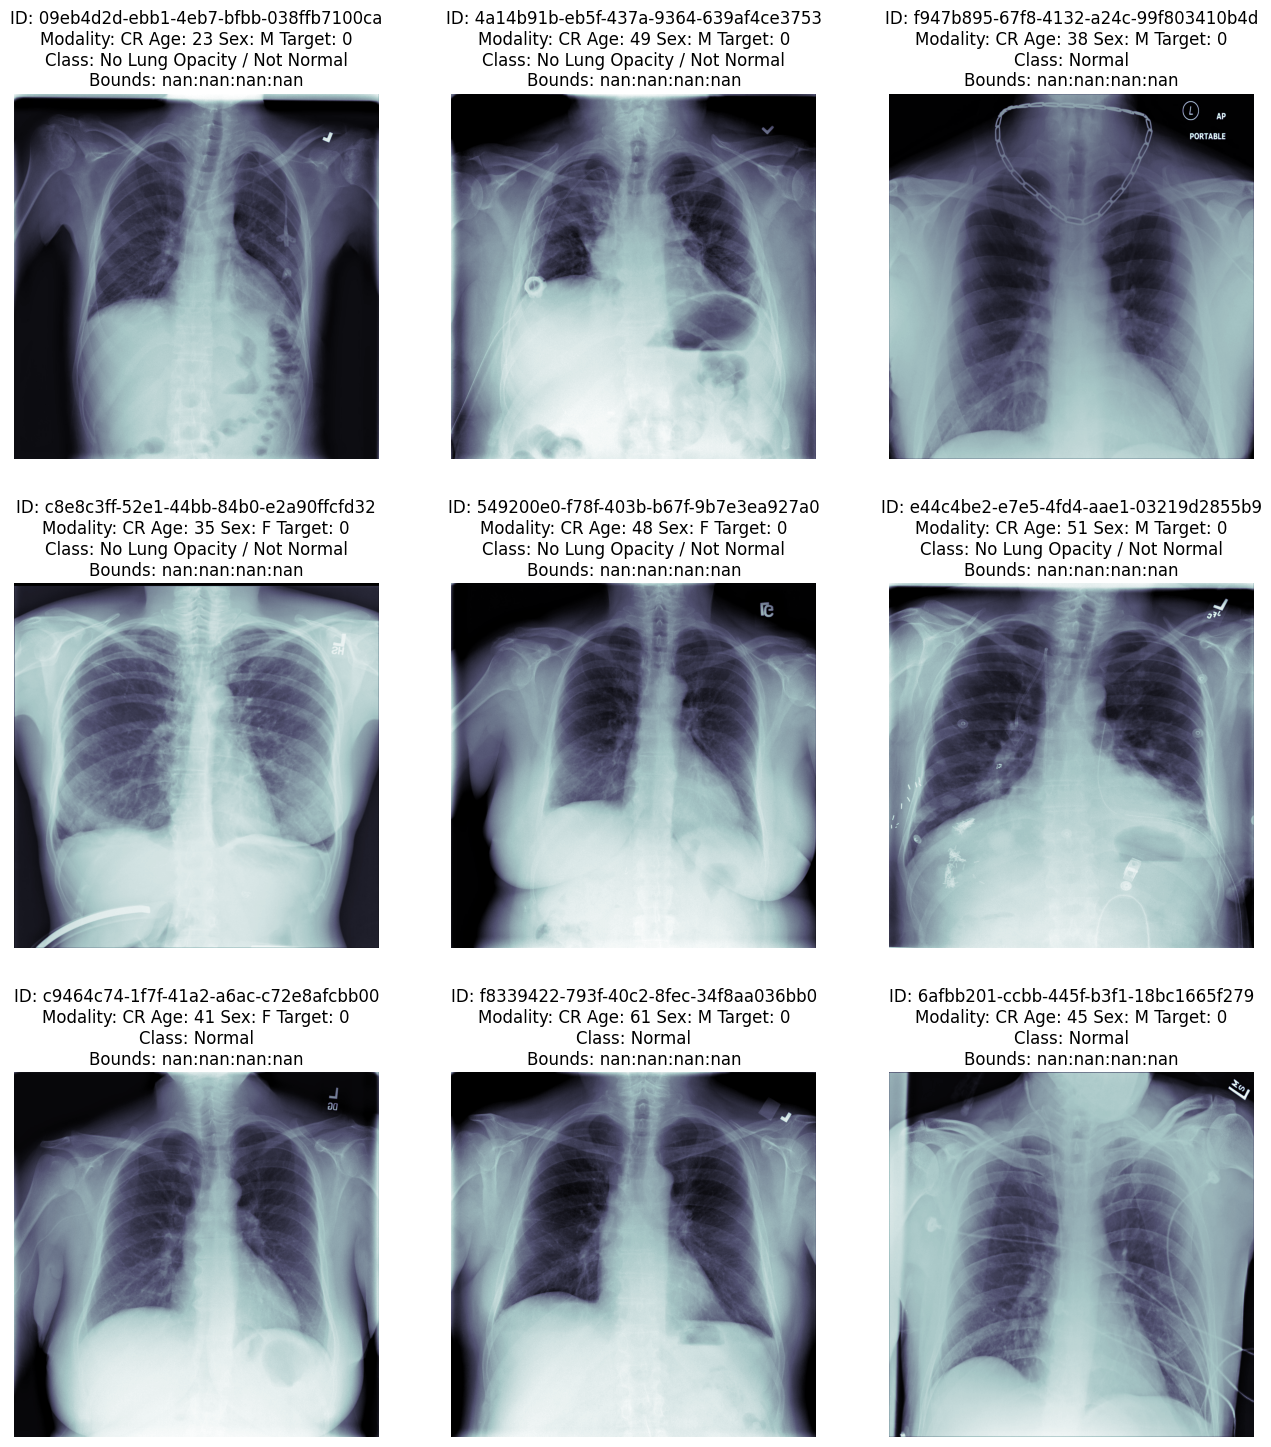

In [26]:
# checking few images which does not have pneuonia
inspectImages(training_data[training_data['Target']==0].sample(9))

In [28]:
def readDCIMData(rowData):
    dcm_file = os.path.join('C:/Users/Yogita/Downloads/stage_2_train_images', '{}.dcm'.format(rowData.patientId))
    dcm_data = dcm.read_file(dcm_file)
    img = dcm_data.pixel_array
    return dcm_data.PatientSex,dcm_data.PatientAge

In [29]:
training_data['sex'], training_data['age'] = zip(*training_data.apply(readDCIMData, axis=1))
training_data['age'] = training_data.age.astype(int)

In [30]:
training_data.head()

patientId      x      y  width  height  Target  \
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0   
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0   
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0   
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0   
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1   

                          class sex  age  
0  No Lung Opacity / Not Normal   F   51  
1  No Lung Opacity / Not Normal   F   48  
2  No Lung Opacity / Not Normal   M   19  
3                        Normal   M   28  
4                  Lung Opacity   F   32

In [31]:
training_data.describe(include="all").T

count unique                                   top   freq  \
patientId    30227  26684  3239951b-6211-4290-b237-3d9ad17176db      4   
x           9555.0    NaN                                   NaN    NaN   
y           9555.0    NaN                                   NaN    NaN   
width       9555.0    NaN                                   NaN    NaN   
height      9555.0    NaN                                   NaN    NaN   
Target     30227.0    NaN                                   NaN    NaN   
class        30227      3          No Lung Opacity / Not Normal  11821   
sex          30227      2                                     M  17216   
age        30227.0    NaN                                   NaN    NaN   

                 mean         std   min    25%    50%    75%    max  
patientId         NaN         NaN   NaN    NaN    NaN    NaN    NaN  
x          394.047724  204.574172   2.0  207.0  324.0  594.0  835.0  
y           366.83956  148.940488   2.0  249.0  365.0  478.5  881.0  
width      218.471376   59.289475  40.0  177.0  217.0  259.0  528.0  
height     329.269702  157.750755  45.0  203.0  298.0  438.0  942.0  
Target       0.316108    0.464963   0.0    0.0    0.0    1.0    1.0  
class             NaN         NaN   NaN    NaN    NaN    NaN    NaN  
sex               NaN         NaN   NaN    NaN    NaN    NaN    NaN  
age         46.797764    16.89294   1.0   34.0   49.0   59.0  155.0

In [32]:
# The mean age is 46 years , where as minimum age is 1 year and the max age is 155 which seems to be an outlier
# 50% of the patiens are of aroudn 49 age , the std deviation is 16 which sugges that age is not normally distubuted

Text(0.5, 1.0, 'Sex and Target for Chest Exams')

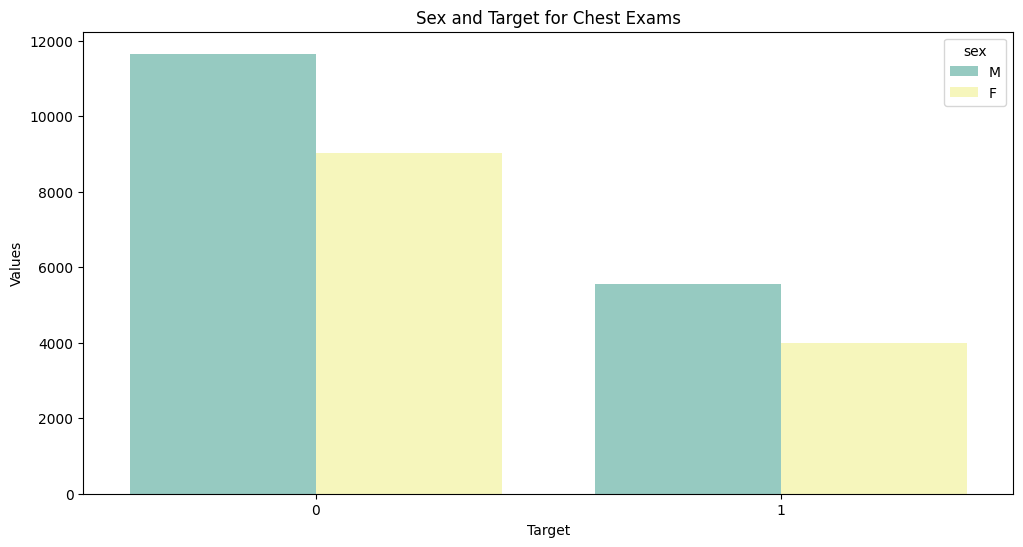

In [33]:
# Distbution of Sex Among the tragets
fig, ax = plt.subplots(nrows = 1, figsize = (12, 6))
temp = training_data.groupby('Target')['sex'].value_counts()
data_target_class = pd.DataFrame(data = {'Values': temp.values}, index = temp.index).reset_index()
sns.barplot(ax = ax, x = 'Target', y = 'Values', hue = 'sex', data = data_target_class, palette = 'Set3')
plt.title('Sex and Target for Chest Exams')

# the number of males in both category are higher than women

Text(0.5, 1.0, 'Sex and class for Chest Exams')

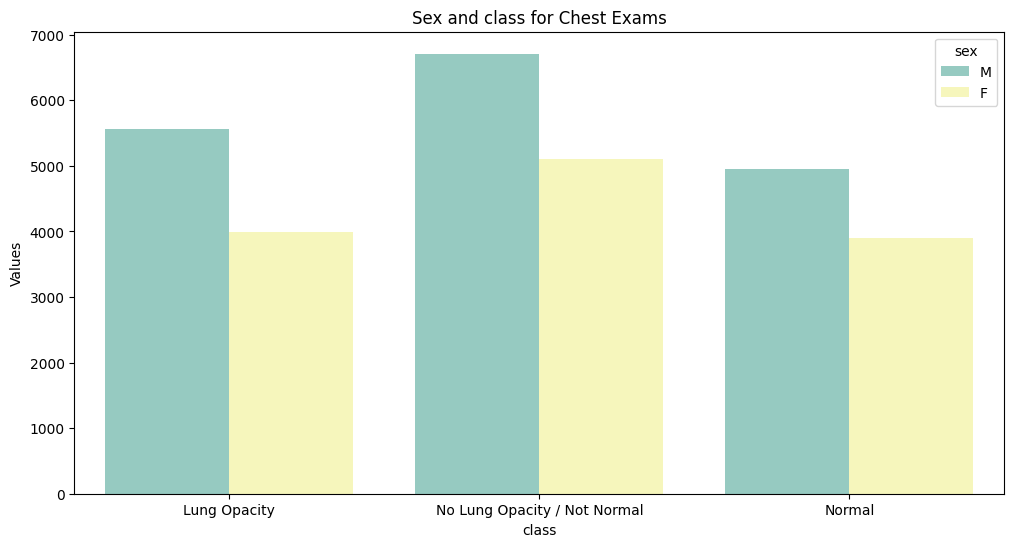

In [34]:
## Distbution of Sex Among the classes
fig, ax = plt.subplots(nrows = 1, figsize = (12, 6))
temp = training_data.groupby('class')['sex'].value_counts()
data_target_class = pd.DataFrame(data = {'Values': temp.values}, index = temp.index).reset_index()
sns.barplot(ax = ax, x = 'class', y = 'Values', hue = 'sex', data = data_target_class, palette = 'Set3')
plt.title('Sex and class for Chest Exams')

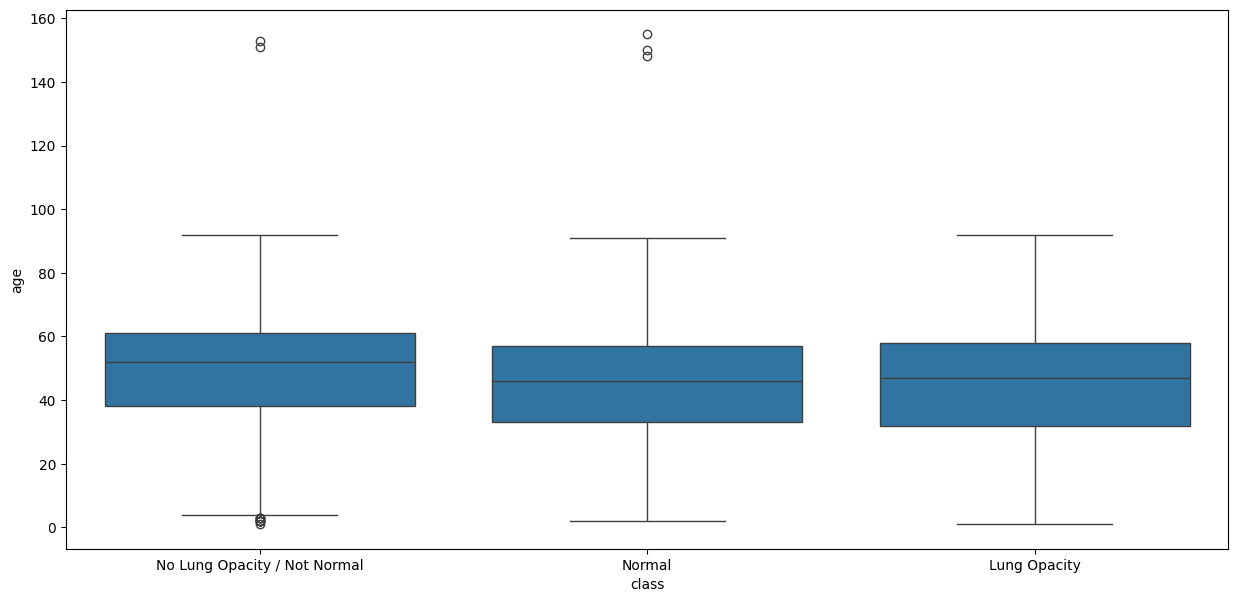

In [35]:
plt.figure(figsize=(15,7))
sns.boxplot(x='class', y='age', data= training_data)
plt.show()

Distribution of `Age`: Overall and Target = 1


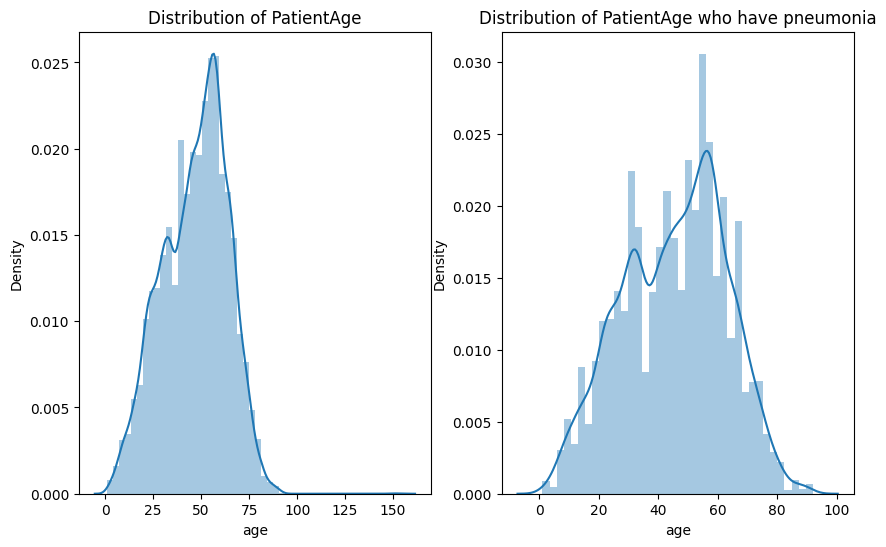

In [36]:
print('Distribution of `Age`: Overall and Target = 1')
fig = plt.figure(figsize = (10, 6))

ax = fig.add_subplot(121)
g = (sns.distplot(training_data['age']).set_title('Distribution of PatientAge'))

ax = fig.add_subplot(122)
g = (sns.distplot(training_data.loc[training_data['Target'] == 1, 'age']).set_title('Distribution of PatientAge who have pneumonia'))

# Overall Distrubution of Age looks normal with very little skwe
# Distubution of Patients afe who have penuomonia are a left skewed 

In [38]:
training_data["class"].value_counts()

class
No Lung Opacity / Not Normal    11821
Lung Opacity                     9555
Normal                           8851
Name: count, dtype: int64

In [39]:
# Pre Processing the image
images = []
ADJUSTED_IMAGE_SIZE = 128
imageList = []
classLabels = []
labels = []
originalImage = []

# Function to read the image from the path and reshaping it.
def readAndReshapeImage(image):
    img = np.array(image).astype(np.uint8)
    res = cv2.resize(img,(ADJUSTED_IMAGE_SIZE,ADJUSTED_IMAGE_SIZE), interpolation = cv2.INTER_LINEAR)
    return res

# Reading the image and resizing it
def populateImage(rowData):
    for index, row in rowData.iterrows():
        patientId = row.patientId
        classlabel = row["Target"]
        folder_name = 'stage_2_train_images'
        current_directory = os.getcwd()
        dcm_file = os.path.join('C:/Users/Yogita/Downloads/stage_2_train_images', '{}.dcm'.format(patientId))
        dcm_data = dcm.read_file(dcm_file)
        img = dcm_data.pixel_array
        # Converting the image to 3 channels as the dicom image pixel does not have colour classes wiht it.
        if len(img.shape) != 3 or img.shape[2] != 3:
            img = np.stack((img,) * 3, -1)
        imageList.append(readAndReshapeImage(img))
        classLabels.append(classlabel)
    tmpImages = np.array(imageList)
    tmpLabels = np.array(classLabels)
    return tmpImages,tmpLabels


In [40]:
# Taking 5000 samples of two target class 0 and 1 each from the dataset.
sample_trainigdata = training_data.groupby('Target', group_keys=False).apply(lambda x: x.sample(5000))

# Checking the training data set with class distbution.
sample_trainigdata["Target"].value_counts()

Target
0    5000
1    5000
Name: count, dtype: int64

In [41]:
sample_trainigdata.head()

patientId   x   y  width  height  Target  \
22729  cd1debc0-a659-438e-a793-bddc503683c5 NaN NaN    NaN     NaN       0   
18009  ab0aa9ce-26ae-47cf-a157-146fa3d90fda NaN NaN    NaN     NaN       0   
16326  9e3268e6-92f8-49f4-b703-cb797ce60ce5 NaN NaN    NaN     NaN       0   
16471  9f52af79-905b-4720-8c9d-668ed47dad8e NaN NaN    NaN     NaN       0   
23827  d656b7a1-1ba1-4ee8-ac6a-71fb8e610548 NaN NaN    NaN     NaN       0   

                              class sex  age  
22729  No Lung Opacity / Not Normal   F   44  
18009  No Lung Opacity / Not Normal   M   56  
16326  No Lung Opacity / Not Normal   M   67  
16471                        Normal   M   38  
23827                        Normal   F   63

In [42]:
sample_trainigdata.drop(columns=['class'], inplace=True)

In [43]:
images,labels = populateImage(sample_trainigdata)

In [44]:
images.shape , labels.shape

((10000, 128, 128, 3), (10000,))

In [45]:
## check the unique labels
np.unique(labels),len(np.unique(labels))

(array([0, 1]), 2)

In [46]:
enc = LabelBinarizer()
y2 = enc.fit_transform(labels)

In [47]:
## splitting into train ,test and validation data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, y2, test_size=0.3, random_state=50)
X_test, X_val, y_test, y_val = train_test_split(X_test,y_test, test_size = 0.5, random_state=50)

In [48]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7000, 128, 128, 3), (1500, 128, 128, 3), (7000, 1), (1500, 1))

In [49]:
X_test.shape, X_val.shape, y_test.shape, y_val.shape

((1500, 128, 128, 3), (1500, 128, 128, 3), (1500, 1), (1500, 1))

In [50]:
# Function to create a dataframe for results
def createResultDf(name,accuracy,testscore):
    result = pd.DataFrame({'Method':[name], 'accuracy': [accuracy] ,'Test Score':[testscore]})
    return result

# Basic CNN

In [32]:
def cnn_model(height, width, num_channels, num_classes, loss='categorical_crossentropy', metrics=['accuracy']):
    batch_size = None

    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(5, 5), padding='same', 
                     activation='relu', input_shape=(height, width, num_channels)))


    model.add(Conv2D(filters=32, kernel_size=(5, 5), padding='same', 
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))


    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', 
                     activation='relu'))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', 
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', 
                     activation='relu'))
    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', 
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(256, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation="softmax"))
    model.compile(optimizer=RMSprop(), loss=loss, metrics=metrics)
    model.summary()
    return model

# Assuming you have already defined the shapes of your data
height, width, num_channels = 128, 128, 3
num_classes = 3

# Create and compile the model
model = cnn_model(height, width, num_channels, num_classes)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      25632     
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 32)        0         
 D)                                                              
                                                                 
 dropout_2 (Dropout)         (None, 64, 64, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 64)        36928     
                                                      

In [21]:
history = model.fit(X_train, 
                  y_train, 
                  epochs = 10, validation_data = (X_val,y_val),
                  batch_size = 32)

Epoch 1/10
662/662 [==============================] - 1009s 2s/step - loss: 3.0846 - accuracy: 0.4610 - val_loss: 1.1569 - val_accuracy: 0.3506
Epoch 2/10
662/662 [==============================] - 1056s 2s/step - loss: 0.8899 - accuracy: 0.5697 - val_loss: 0.8288 - val_accuracy: 0.5918
Epoch 3/10
662/662 [==============================] - 962s 1s/step - loss: 0.8510 - accuracy: 0.5896 - val_loss: 0.8356 - val_accuracy: 0.6090
Epoch 4/10
662/662 [==============================] - 976s 1s/step - loss: 0.8405 - accuracy: 0.5977 - val_loss: 1.0664 - val_accuracy: 0.4168
Epoch 5/10
662/662 [==============================] - 932s 1s/step - loss: 0.8313 - accuracy: 0.6013 - val_loss: 0.7880 - val_accuracy: 0.6225
Epoch 6/10
662/662 [==============================] - 923s 1s/step - loss: 0.8040 - accuracy: 0.6212 - val_loss: 0.9000 - val_accuracy: 0.5594
Epoch 7/10
662/662 [==============================] - 917s 1s/step - loss: 0.8144 - accuracy: 0.6177 - val_loss: 0.8163 - val_accuracy: 0.63

In [22]:
# Saving model and its weights for future use
model.save('history.h5')
model.save_weights('basiccnn_weights1.h5')

In [25]:
## evaluating the accuracy, we have only got accuracy of 62-64% where as the training accuracy is around 60%
fcl_loss, fcl_accuracy = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', fcl_loss)
print('Test accuracy:', fcl_accuracy)

142/142 [==============================] - 62s 431ms/step - loss: 0.7850 - accuracy: 0.6345
Test loss: 0.7850446701049805
Test accuracy: 0.6345390677452087


In [ ]:
## PLottting the accuracy vs loss graph
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(10)


line_colors = ['#FF5733', '#33D7FF', '#FFC300', '#DAF7A6']
line_styles = ['-', '--', '-.', ':']

plt.figure(figsize=(16, 8))

# Training and Validation Accuracy Plot.
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', color=line_colors[0], linestyle=line_styles[0], linewidth=2)
plt.plot(epochs_range, val_acc, label='Validation Accuracy', color=line_colors[1], linestyle=line_styles[1], linewidth=2)
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Epochs', fontsize=12, fontweight='bold')
plt.ylabel('Accuracy', fontsize=12, fontweight='bold')
plt.grid(True)
plt.gca().set_facecolor('#EAEAF2')

# Training and Validation Loss Plot.
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', color=line_colors[2], linestyle=line_styles[2], linewidth=2)
plt.plot(epochs_range, val_loss, label='Validation Loss', color=line_colors[0], linestyle=line_styles[3], linewidth=2)
plt.legend(loc='upper right')
plt.title('Training and Validation Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epochs', fontsize=12, fontweight='bold')
plt.ylabel('Loss', fontsize=12, fontweight='bold')
plt.grid(True)
plt.gca().set_facecolor('#EAEAF2')


plt.tight_layout()
plt.show()

# VGG16

In [84]:
## Creating a Copy
X_train_vgg = X_train.copy()
X_val_vgg = X_val.copy()
X_test_vgg = X_test.copy()

In [85]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

# Preprocessing input
train_ds = preprocess_input(X_train_vgg) 
train_val_df = preprocess_input(X_val_vgg)

In [86]:
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Nadam
base_model = VGG16(weights="imagenet", include_top=False, input_shape=X_train[0].shape)
for layer in base_model.layers[:20]:
    layer.trainable=False
for layer in base_model.layers[20:]:
    layer.trainable=True

flatten_layer = layers.Flatten()
dense_layer_0 = layers.Dense(1024, activation='relu')
dense_layer_1 = layers.Dense(512, activation='relu')
dense_layer_2 = layers.Dense(256, activation='relu')
dropout_layer = layers.Dropout(0.5)
prediction_layer = layers.Dense(1, activation='sigmoid')
dense_layer_3 = layers.Dense(64, activation='relu')
global_average_pooling_layer = GlobalAveragePooling2D()

cnn_VGG16_model = models.Sequential([
    base_model,
    global_average_pooling_layer,
    flatten_layer,
    dense_layer_0,
    dense_layer_1,
    dropout_layer,
    BatchNormalization(),
    dense_layer_2,
    dropout_layer,  
    dense_layer_3,   
    dropout_layer,  
    BatchNormalization(),
    prediction_layer
])

cnn_VGG16_model.compile(
    optimizer=optimizers.Nadam(learning_rate=0.001),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy'],
)

# Data augmentation
data_augmentation = ImageDataGenerator(
    width_shift_range=0.3,  
    height_shift_range=0.3,  
    shear_range=0.3, 
    zoom_range=0.3,
    zca_whitening=False,
    fill_mode='nearest'
)

train_ds = data_augmentation.flow(train_ds, y_train, batch_size=32)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)


In [87]:
history_1 = cnn_VGG16_model.fit(train_ds, epochs=25, batch_size=64, validation_data=(train_val_df, y_val), callbacks=reduce_lr)

Epoch 1/25
219/219 [==============================] - 661s 3s/step - loss: 0.6773 - accuracy: 0.6647 - val_loss: 0.4949 - val_accuracy: 0.7593 - lr: 0.0010
Epoch 2/25
219/219 [==============================] - 780s 4s/step - loss: 0.5747 - accuracy: 0.7223 - val_loss: 0.6343 - val_accuracy: 0.7140 - lr: 0.0010
Epoch 3/25
219/219 [==============================] - 763s 3s/step - loss: 0.5481 - accuracy: 0.7401 - val_loss: 0.4965 - val_accuracy: 0.7607 - lr: 0.0010
Epoch 4/25
219/219 [==============================] - 810s 4s/step - loss: 0.5273 - accuracy: 0.7491 - val_loss: 0.5145 - val_accuracy: 0.7620 - lr: 0.0010
Epoch 5/25
219/219 [==============================] - 804s 4s/step - loss: 0.5139 - accuracy: 0.7639 - val_loss: 0.4943 - val_accuracy: 0.7653 - lr: 5.0000e-04
Epoch 6/25
219/219 [==============================] - 783s 4s/step - loss: 0.5089 - accuracy: 0.7706 - val_loss: 0.5429 - val_accuracy: 0.7620 - lr: 5.0000e-04
Epoch 7/25
219/219 [==============================] - 75

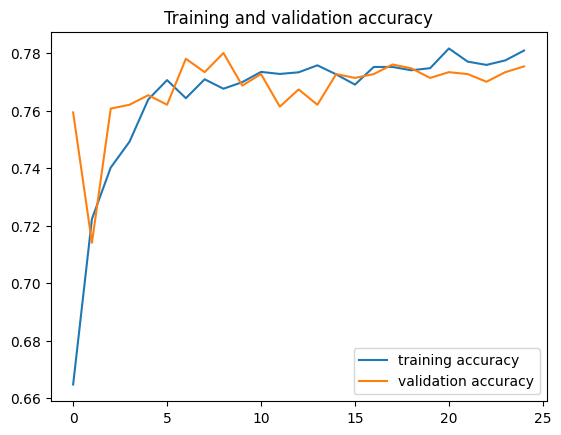

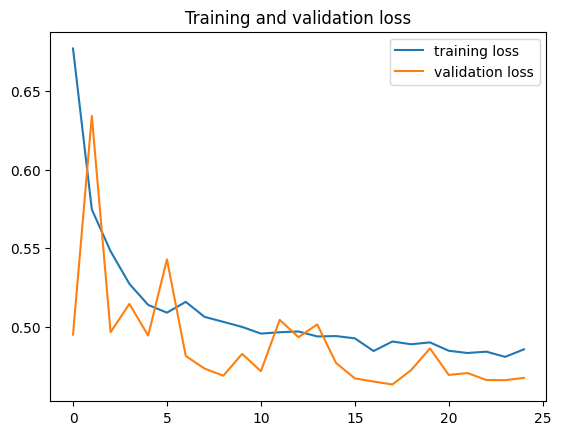

In [88]:
# Accuracy and Loss plots

accuracy = history_1.history['accuracy']
val_accuracy = history_1.history['val_accuracy']
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs   = range(len(accuracy))

plt.plot  (epochs, accuracy, label = 'training accuracy')
plt.plot  (epochs, val_accuracy, label = 'validation accuracy')
plt.title ('Training and validation accuracy')
plt.legend(loc = 'lower right')
plt.figure()

plt.plot  (epochs, loss, label = 'training loss')
plt.plot  (epochs, val_loss, label = 'validation loss')
plt.legend(loc = 'upper right')
plt.title ('Training and validation loss')
plt.show()

In [92]:
# As observed, there is no such case of overfitting or underfitting. 

### Evaluating metrics on unseen data

In [90]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Predicting labels for test data
Y_pred = cnn_VGG16_model.predict(X_test_vgg)
Y_pred_binary = (Y_pred > 0.5).astype(int)

# Calculating evaluation metrics
accuracy = accuracy_score(y_test, Y_pred_binary)
precision = precision_score(y_test, Y_pred_binary)
recall = recall_score(y_test, Y_pred_binary)
f1 = f1_score(y_test, Y_pred_binary)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

47/47 [==============================] - 138s 3s/step
Accuracy: 0.7746666666666666
Precision: 0.7837116154873164
Recall: 0.7693315858453473
F1 Score: 0.7764550264550265


In [93]:
# Saving model and its weights for future use
cnn_VGG16_model.save('VGG16_model.h5')
cnn_VGG16_model.save_weights('VGG16_weights.h5')

# ResNet50

In [29]:
# Creating a Copy
X_train_resnet = X_train.copy()
X_val_resnet = X_val.copy()
X_test_resnet = X_test.copy()

train_ds = preprocess_input(X_train_resnet) 
train_val_df = preprocess_input(X_val_resnet)

In [30]:
train_ds.shape, train_val_df.shape

((7000, 128, 128, 3), (1500, 128, 128, 3))

In [31]:
import tensorflow
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Nadam

base_model = ResNet50(input_shape=X_train[0].shape,
                      weights='imagenet',
                      include_top=False) 

x = base_model.output
x = GlobalAveragePooling2D()(x) 
# x = Dense(1024, activation='relu')(x)
# x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x) 
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x) 
x = Dense(128, activation='relu')(x) 
x = Dropout(0.5)(x)
preds = Dense(1, activation='sigmoid')(x) 

model_resnet50 = Model(inputs=base_model.input, outputs=preds)

for layer in model_resnet50.layers[:150]:
    layer.trainable=False
for layer in model_resnet50.layers[150:]:
    layer.trainable=True

model_resnet50.compile(optimizer=tensorflow.optimizers.Adam(),
                       loss=tf.keras.losses.BinaryCrossentropy(),
                       metrics=['accuracy'])


In [32]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)

In [33]:
resnet_history =model_resnet50.fit(train_ds, y_train, epochs=15, batch_size=64, validation_data=(train_val_df,y_val), callbacks=reduce_lr)
# visualkeras.layered_view(cnn_resnet_model,legend = True)

Epoch 1/15
110/110 [==============================] - 370s 3s/step - loss: 0.5885 - accuracy: 0.7059 - val_loss: 0.5340 - val_accuracy: 0.7260 - lr: 0.0010
Epoch 2/15
110/110 [==============================] - 288s 3s/step - loss: 0.5281 - accuracy: 0.7491 - val_loss: 0.5276 - val_accuracy: 0.7180 - lr: 0.0010
Epoch 3/15
110/110 [==============================] - 300s 3s/step - loss: 0.5224 - accuracy: 0.7590 - val_loss: 0.5656 - val_accuracy: 0.7407 - lr: 0.0010
Epoch 4/15
110/110 [==============================] - 277s 3s/step - loss: 0.5074 - accuracy: 0.7580 - val_loss: 0.5769 - val_accuracy: 0.7300 - lr: 0.0010
Epoch 5/15
110/110 [==============================] - 319s 3s/step - loss: 0.5013 - accuracy: 0.7609 - val_loss: 0.5691 - val_accuracy: 0.7740 - lr: 0.0010
Epoch 6/15
110/110 [==============================] - 286s 3s/step - loss: 0.4750 - accuracy: 0.7791 - val_loss: 0.4952 - val_accuracy: 0.7720 - lr: 5.0000e-04
Epoch 7/15
110/110 [==============================] - 326s 3

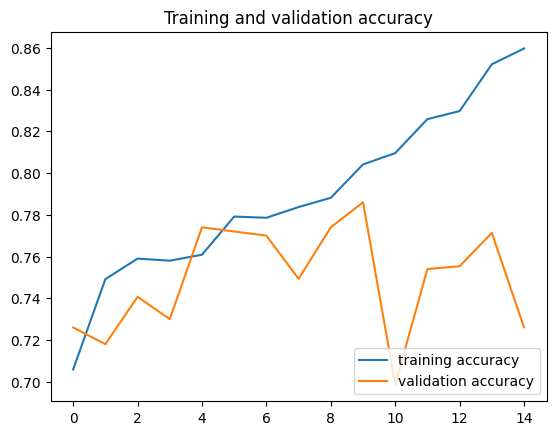

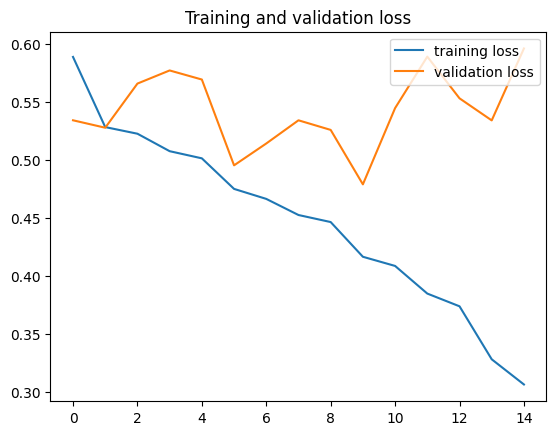

In [34]:
# Accuracy and Loss plots

accuracy = resnet_history.history['accuracy']
val_accuracy = resnet_history.history['val_accuracy']
loss = resnet_history.history['loss']
val_loss = resnet_history.history['val_loss']

epochs   = range(len(accuracy))

plt.plot  (epochs, accuracy, label = 'training accuracy')
plt.plot  (epochs, val_accuracy, label = 'validation accuracy')
plt.title ('Training and validation accuracy')
plt.legend(loc = 'lower right')
plt.figure()

plt.plot  (epochs, loss, label = 'training loss')
plt.plot  (epochs, val_loss, label = 'validation loss')
plt.legend(loc = 'upper right')
plt.title ('Training and validation loss')
plt.show()

### Evaluating metrics on unseen data.

In [36]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Predicting labels for test data
Y_pred = model_resnet50.predict(X_test_resnet)
Y_pred_binary = (Y_pred > 0.5).astype(int)

# Calculating evaluation metrics
accuracy = accuracy_score(y_test, Y_pred_binary)
precision = precision_score(y_test, Y_pred_binary)
recall = recall_score(y_test, Y_pred_binary)
f1 = f1_score(y_test, Y_pred_binary)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

47/47 [==============================] - 43s 832ms/step
Accuracy: 0.49133333333333334
Precision: 0.0
Recall: 0.0
F1 Score: 0.0


# Inception

In [37]:
## Creating a Copy
X_train_incep = X_train.copy()
X_val_incep = X_val.copy()
X_test_incep = X_test.copy()

In [38]:
## Preprocessing input
train_ds = preprocess_input(X_train_incep) 
train_val_df = preprocess_input(X_val_incep)

In [46]:
train_ds.shape, train_val_df.shape

((7000, 128, 128, 3), (1500, 128, 128, 3))

In [47]:
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input
from tensorflow.keras import layers, models

base_model_inception = InceptionResNetV2(weights="imagenet", include_top=False, input_shape=X_train[0].shape)
base_model_inception.trainable = False 

flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(50, activation='relu')
dense_layer_2 = layers.Dense(20, activation='relu')
dense_layer_3 = layers.Dense(10, activation='relu')
prediction_layer = layers.Dense(1, activation='sigmoid')
global_average_pooling_layer = GlobalAveragePooling2D()
dropout_layer = layers.Dropout(0.5)

cnn_inception_model = models.Sequential([
    base_model_inception,
    global_average_pooling_layer,
    flatten_layer,
    dense_layer_1,
    dropout_layer,
    dense_layer_2,
    dense_layer_3,
    dropout_layer,
    BatchNormalization(),
    prediction_layer
])
cnn_inception_model.compile(
    optimizer='Adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [48]:
# Training the model
history = cnn_inception_model.fit(train_ds, y_train, epochs=20, batch_size=64, validation_data=(train_val_df,y_val) ,callbacks=reduce_lr)

Epoch 1/20
110/110 [==============================] - 288s 2s/step - loss: 0.7230 - accuracy: 0.5471 - val_loss: 0.6182 - val_accuracy: 0.7040 - lr: 0.0010
Epoch 2/20
110/110 [==============================] - 370s 3s/step - loss: 0.6542 - accuracy: 0.6289 - val_loss: 0.5887 - val_accuracy: 0.7253 - lr: 0.0010
Epoch 3/20
110/110 [==============================] - 383s 3s/step - loss: 0.6104 - accuracy: 0.6864 - val_loss: 0.5766 - val_accuracy: 0.7367 - lr: 0.0010
Epoch 4/20
110/110 [==============================] - 415s 4s/step - loss: 0.5857 - accuracy: 0.7129 - val_loss: 0.5551 - val_accuracy: 0.7447 - lr: 0.0010
Epoch 5/20
110/110 [==============================] - 429s 4s/step - loss: 0.5720 - accuracy: 0.7186 - val_loss: 0.5323 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 6/20
110/110 [==============================] - 443s 4s/step - loss: 0.5634 - accuracy: 0.7210 - val_loss: 0.5215 - val_accuracy: 0.7667 - lr: 0.0010
Epoch 7/20
110/110 [==============================] - 445s 4s/st

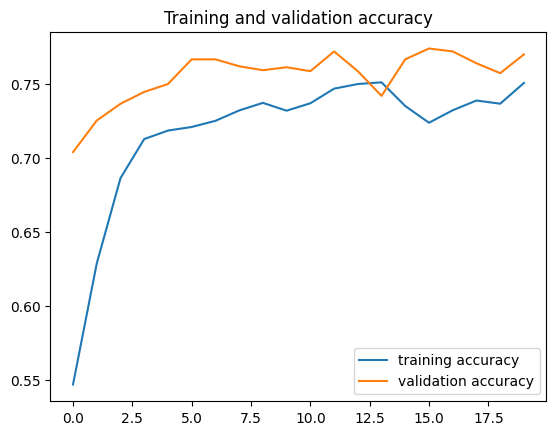

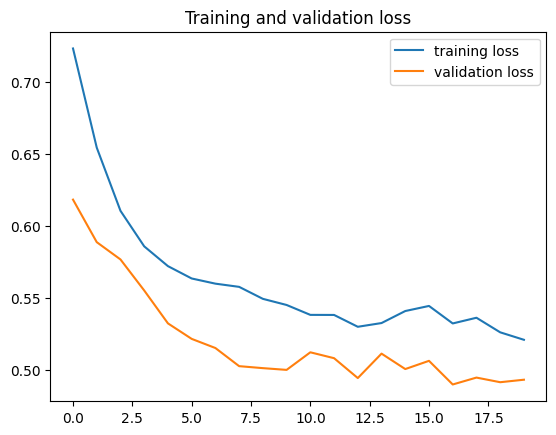

In [49]:
# Accuracy and Loss plots

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(len(accuracy))

plt.plot  (epochs, accuracy, label = 'training accuracy')
plt.plot  (epochs, val_accuracy, label = 'validation accuracy')
plt.title ('Training and validation accuracy')
plt.legend(loc = 'lower right')
plt.figure()

plt.plot  (epochs, loss, label = 'training loss')
plt.plot  (epochs, val_loss, label = 'validation loss')
plt.legend(loc = 'upper right')
plt.title ('Training and validation loss')
plt.show()

### Evaluating metrics on unseen data.

In [51]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Predicting labels for test data
Y_pred = cnn_inception_model.predict(X_test_incep)
Y_pred_binary = (Y_pred > 0.5).astype(int)

# Calculating evaluation metrics
accuracy = accuracy_score(y_test, Y_pred_binary)
precision = precision_score(y_test, Y_pred_binary)
recall = recall_score(y_test, Y_pred_binary)
f1 = f1_score(y_test, Y_pred_binary)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

47/47 [==============================] - 33s 706ms/step
Accuracy: 0.49133333333333334
Precision: 0.0
Recall: 0.0
F1 Score: 0.0


### From here on, we are using 14,000 images for training models instead of 10,000. 

# EfficientNet

In [27]:
# Taking 7000 samples of two target class 0 and 1 each from the dataset.
sample_eff_net = training_data.groupby('Target', group_keys=False).apply(lambda x: x.sample(7000))

# Checking the training data set with class distbution.
sample_eff_net["Target"].value_counts()

Target
0    7000
1    7000
Name: count, dtype: int64

In [28]:
sample_eff_net.shape

(14000, 9)

In [29]:
sample_eff_net.drop(columns=['class'], inplace=True)
images_eff,labels_eff = populateImage(sample_eff_net)

In [30]:
images_eff.shape , labels_eff.shape

((24000, 128, 128, 3), (24000,))

In [31]:
enc = LabelBinarizer()
y2 = enc.fit_transform(labels_eff)

In [32]:
## splitting into train ,test and validation data
from sklearn.model_selection import train_test_split
X_train_eff, X_test_eff, y_train_eff, y_test_eff = train_test_split(images_eff, y2, test_size=0.3, random_state=50)
X_test_eff, X_val_eff, y_test_eff, y_val_eff = train_test_split(X_test_eff,y_test_eff, test_size = 0.5, random_state=50)

In [33]:
X_val_eff.shape, X_train_eff.shape

((3600, 128, 128, 3), (16800, 128, 128, 3))

In [34]:
# Preprocessing input
train_ds = preprocess_input(X_train_eff) 
train_val_df = preprocess_input(X_val_eff)

In [89]:
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2L
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input

base_model_eff = EfficientNetV2L(weights="imagenet", include_top=False, input_shape=X_train[0].shape)
for layer in base_model_eff.layers[:100]:
    layer.trainable=False
for layer in base_model_eff.layers[100:]:
    layer.trainable=True

flatten_layer = layers.Flatten()
dense_layer_0 = layers.Dense(1024, activation='relu')
dense_layer_1 = layers.Dense(512, activation='relu')
dense_layer_2 = layers.Dense(256, activation='relu')
dropout_layer = layers.Dropout(0.5)
prediction_layer = layers.Dense(1, activation='sigmoid')
dense_layer_3 = layers.Dense(64, activation='relu')
global_average_pooling_layer = GlobalAveragePooling2D()

cnn_eff_model = models.Sequential([
    base_model_eff,
    global_average_pooling_layer,
    flatten_layer,
    dense_layer_0,
    dense_layer_1,
    dropout_layer,
    BatchNormalization(),
    dense_layer_2,
    dropout_layer,  
    dense_layer_3,   
    dropout_layer,  
    BatchNormalization(),
    prediction_layer
])

cnn_eff_model.compile(
    optimizer=optimizers.Nadam(learning_rate=0.001),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy'],
)

# Data augmentation
data_augmentation = ImageDataGenerator(
    width_shift_range=0.3,  
    height_shift_range=0.3,  
    shear_range=0.3, 
    zoom_range=0.3,
    zca_whitening=False,
    fill_mode='nearest'
)

train_ds = data_augmentation.flow(train_ds, y_train_eff, batch_size=32)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)

In [90]:
history_1 = cnn_eff_model.fit(train_ds, epochs=15, batch_size=64, validation_data=(train_val_df, y_val_eff), callbacks=reduce_lr)

Epoch 1/15
307/307 [==============================] - 613s 2s/step - loss: 0.6347 - accuracy: 0.6809 - val_loss: 0.5329 - val_accuracy: 0.7767 - lr: 0.0010
Epoch 2/15
307/307 [==============================] - 565s 2s/step - loss: 0.5436 - accuracy: 0.7513 - val_loss: 0.4757 - val_accuracy: 0.7981 - lr: 0.0010
Epoch 3/15
307/307 [==============================] - 599s 2s/step - loss: 0.5116 - accuracy: 0.7681 - val_loss: 0.4689 - val_accuracy: 0.8010 - lr: 0.0010
Epoch 4/15
307/307 [==============================] - 561s 2s/step - loss: 0.5017 - accuracy: 0.7682 - val_loss: 0.4635 - val_accuracy: 0.8076 - lr: 0.0010
Epoch 5/15
307/307 [==============================] - 578s 2s/step - loss: 0.4895 - accuracy: 0.7739 - val_loss: 0.4479 - val_accuracy: 0.8048 - lr: 0.0010
Epoch 6/15
307/307 [==============================] - 593s 2s/step - loss: 0.4894 - accuracy: 0.7714 - val_loss: 0.4477 - val_accuracy: 0.7967 - lr: 0.0010
Epoch 7/15
307/307 [==============================] - 560s 2s/st

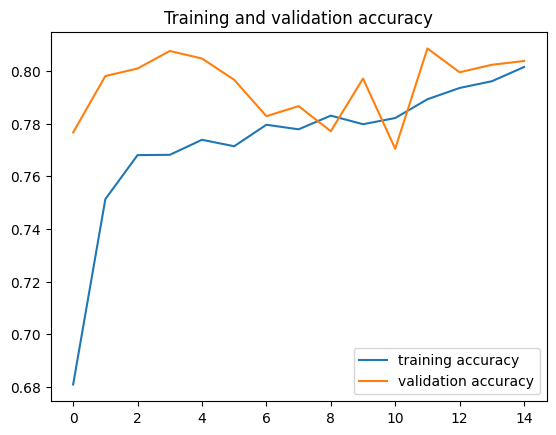

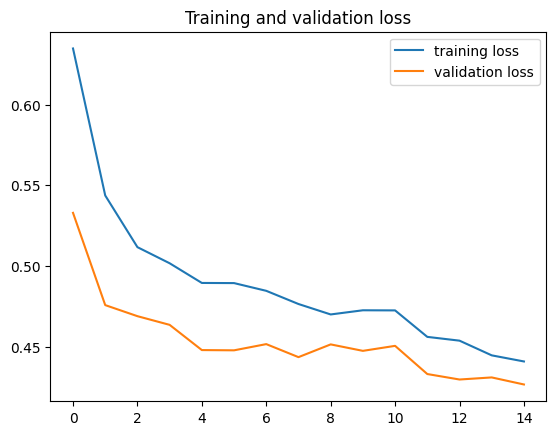

In [91]:
# Accuracy and Loss plots

accuracy = history_1.history['accuracy']
val_accuracy = history_1.history['val_accuracy']
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs   = range(len(accuracy))

plt.plot  (epochs, accuracy, label = 'training accuracy')
plt.plot  (epochs, val_accuracy, label = 'validation accuracy')
plt.title ('Training and validation accuracy')
plt.legend(loc = 'lower right')
plt.figure()

plt.plot  (epochs, loss, label = 'training loss')
plt.plot  (epochs, val_loss, label = 'validation loss')
plt.legend(loc = 'upper right')
plt.title ('Training and validation loss')
plt.show()

### Evaluating metrics on unseen data

In [92]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Predicting labels for test data
Y_pred = cnn_eff_model.predict(X_test_eff)
Y_pred_binary = (Y_pred > 0.5).astype(int)

# Calculating evaluation metrics
accuracy = accuracy_score(y_test_eff, Y_pred_binary)
precision = precision_score(y_test_eff, Y_pred_binary)
recall = recall_score(y_test_eff, Y_pred_binary)
f1 = f1_score(y_test_eff, Y_pred_binary)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

66/66 [==============================] - 48s 656ms/step
Accuracy: 0.7933333333333333
Precision: 0.7712811693895099
Recall: 0.8422535211267606
F1 Score: 0.8052064631956912


# DenseNet201

In [51]:
# Preprocessing input
train_ds = preprocess_input(X_train) 
train_val_df = preprocess_input(X_val)

In [52]:
train_ds.shape, train_val_df.shape

((7000, 128, 128, 3), (1500, 128, 128, 3))

In [53]:
from tensorflow.keras.applications.densenet import DenseNet201 
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

base_model_dense = DenseNet201 (weights="imagenet", include_top=False, input_shape=X_train[0].shape)
for layer in base_model_dense.layers[:100]:
    layer.trainable=False
for layer in base_model_dense.layers[100:]:
    layer.trainable=True

flatten_layer = layers.Flatten()
dense_layer_0 = layers.Dense(1024, activation='relu')
dense_layer_1 = layers.Dense(512, activation='relu')
dense_layer_2 = layers.Dense(256, activation='relu')
dropout_layer = layers.Dropout(0.5)
prediction_layer = layers.Dense(1, activation='sigmoid')
dense_layer_3 = layers.Dense(64, activation='relu')
global_average_pooling_layer = GlobalAveragePooling2D()

cnn_dense_model = models.Sequential([
    base_model_dense,
    global_average_pooling_layer,
    flatten_layer,
    dense_layer_0,
    dense_layer_1,
    dropout_layer,
    BatchNormalization(),
    dense_layer_2,
    dropout_layer,  
    dense_layer_3,   
    dropout_layer,  
    BatchNormalization(),
    prediction_layer
])

cnn_dense_model.compile(
    optimizer=optimizers.Nadam(learning_rate=0.001),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy'],
)

# Data augmentation
data_augmentation = ImageDataGenerator(
    width_shift_range=0.3,  
    height_shift_range=0.3,  
    shear_range=0.3, 
    zoom_range=0.3,
    zca_whitening=False,
    fill_mode='nearest'
)

train_ds = data_augmentation.flow(train_ds, y_train, batch_size=32)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)

In [23]:
densenet_history = cnn_dense_model.fit(train_ds, epochs=10, batch_size=64, validation_data=(train_val_df, y_val), callbacks=reduce_lr)

Epoch 1/10


219/219 [==============================] - 934s 3s/step - loss: 0.6433 - accuracy: 0.6824 - val_loss: 1.9242 - val_accuracy: 0.7900 - lr: 0.0010
Epoch 2/10
219/219 [==============================] - 890s 4s/step - loss: 0.5095 - accuracy: 0.7694 - val_loss: 0.7554 - val_accuracy: 0.7800 - lr: 0.0010
Epoch 3/10
219/219 [==============================] - 1039s 5s/step - loss: 0.4823 - accuracy: 0.7861 - val_loss: 0.4497 - val_accuracy: 0.7980 - lr: 0.0010
Epoch 4/10
219/219 [==============================] - 1086s 5s/step - loss: 0.4565 - accuracy: 0.7927 - val_loss: 0.4696 - val_accuracy: 0.8047 - lr: 0.0010
Epoch 5/10
219/219 [==============================] - 1085s 5s/step - loss: 0.4480 - accuracy: 0.7949 - val_loss: 0.4899 - val_accuracy: 0.8067 - lr: 0.0010
Epoch 6/10
219/219 [==============================] - 1060s 5s/step - loss: 0.4379 - accuracy: 0.8050 - val_loss: 0.4950 - val_accuracy: 0.7993 - lr: 0.0010
Epoch 7/10
219/219 [==============================] - 1069

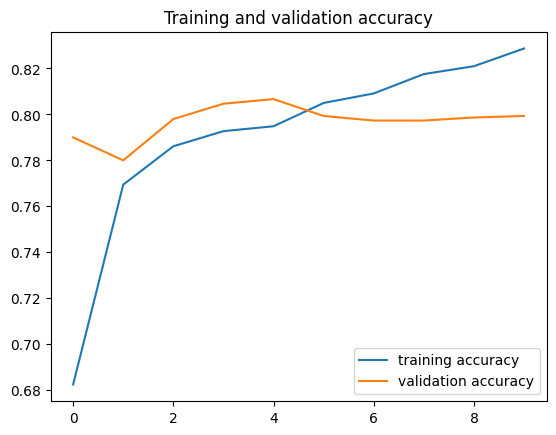

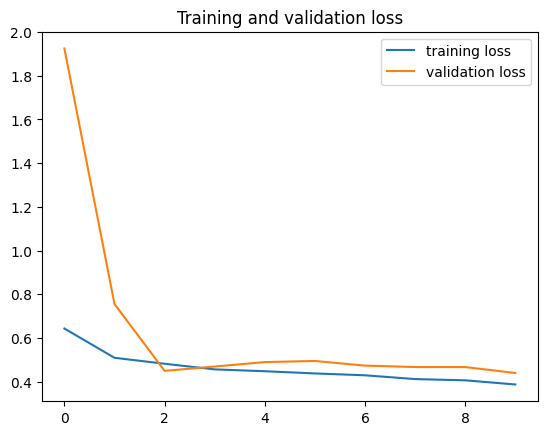

In [24]:
# Accuracy and Loss plots

accuracy = densenet_history.history['accuracy']
val_accuracy = densenet_history.history['val_accuracy']
loss = densenet_history.history['loss']
val_loss = densenet_history.history['val_loss']

epochs   = range(len(accuracy))

plt.plot  (epochs, accuracy, label = 'training accuracy')
plt.plot  (epochs, val_accuracy, label = 'validation accuracy')
plt.title ('Training and validation accuracy')
plt.legend(loc = 'lower right')
plt.figure()

plt.plot  (epochs, loss, label = 'training loss')
plt.plot  (epochs, val_loss, label = 'validation loss')
plt.legend(loc = 'upper right')
plt.title ('Training and validation loss')
plt.show()

### Evaluating metrics on unseen data.

In [25]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Predicting labels for test data
Y_pred = cnn_dense_model.predict(X_test)
Y_pred_binary = (Y_pred > 0.5).astype(int)

# Calculating evaluation metrics
accuracy = accuracy_score(y_test, Y_pred_binary)
precision = precision_score(y_test, Y_pred_binary)
recall = recall_score(y_test, Y_pred_binary)
f1 = f1_score(y_test, Y_pred_binary)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

47/47 [==============================] - 84s 1s/step
Accuracy: 0.5533333333333333
Precision: 0.5875706214689266
Recall: 0.4089121887287025
F1 Score: 0.482225656877898
